In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset


In [ ]:
import os 
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

In [ ]:
CLASS_NAMES = ['bottle', 'cable','capsule','carpet']

In [ ]:
dataset_path = '/content/drive/MyDrive/Padim/mvtec_anomaly_detection'
save_path = '/content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result'

In [ ]:
class MVTecDataset(Dataset):
  def __init__(self, dataset_path=None, class_name= 'metal_nut2', is_train=True, resize=384, cropsize=384):
    assert class_name in CLASS_NAMES, 'class_name: {}, should be in {}'.format(class_name,CLASS_NAMES)
    self.dataset_path = dataset_path
    self.class_name = class_name
    self.is_train = is_train
    self.resize = resize
    self.cropsize = cropsize

    #load dataset
    self.x, self.y, self.mask = self.load_dataset_folder()

    # set transforms
    self.transform_x = T.Compose([T.Resize(resize, Image.ANTIALIAS),
                                  T.CenterCrop(cropsize),
                                  T.ToTensor(),
                                  T.Normalize(0.5,0.5)])
    self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                     T.CenterCrop(cropsize),
                                     T.ToTensor()])
  
  def __getitem__(self, idx):
    x,y,mask = self.x[idx], self.y[idx], self.mask[idx]

    x= Image.open(x).convert('RGB')
    x= self.transform_x(x)

    if y==0:
      mask= torch.zeros([1, self.cropsize, self.cropsize])
    else:
      mask = Image.open(mask)
      mask = self.transform_mask(mask)

    return x,y,mask
  
  def __len__(self):
    return len(self.x)
  
  def load_dataset_folder(self):
    phase = 'train' if self.is_train else 'test'
    x,y,mask = [], [], []

    img_dir = os.path.join(self.dataset_path, self.class_name, phase)
    gt_dir = os.path.join(self.dataset_path, self.class_name, 'ground_truth')

    img_types = sorted(os.listdir(img_dir))
    for img_type in img_types:

      img_type_dir = os.path.join(img_dir, img_type)
      if not os.path.isdir(img_type_dir):
        continue
      img_fpath_list = sorted([os.path.join(img_type_dir,f)
                              for f in os.listdir(img_type_dir)])
      x.extend(img_fpath_list)

      if img_type == 'good':
        y.extend([0]* len(img_fpath_list))
        mask.extend([None]* len(img_fpath_list))
      else :
        y.extend([1]* len(img_fpath_list))
        gt_type_dir = os.path.join(gt_dir, img_type)
        img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
        gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                        for img_fname in img_fname_list]
        mask.extend(gt_fpath_list)

    assert len(x) == len(y), 'number of x and y should be same'

    return list(x), list(y), list(mask)

# model

In [ ]:
import random
from random import sample
import argparse
import numpy as np
import pickle
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.spatial import distance
from skimage import morphology
from scipy.ndimage import gaussian_filter
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
pip install pytorch_pretrained_vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11132 sha256=175d7f4e7f63eeaf261262197af7e6f96abfa0b1e36a666a5645a052e3071e6b
  Stored in directory: /root/.cache/pip/wheels/e6/78/4d/447580dd8e95a2aafa0b85820e811568b6b8a8f5460656c0ee
Successfully built pytorch-pretrained-vit


In [ ]:
from pytorch_pretrained_vit import ViT
#model = ViT('B_16_imagenet1k', pretrained=True)

In [ ]:
model.transformer.blocks[-1]

Block(
  (attn): MultiHeadedSelfAttention(
    (proj_q): Linear(in_features=768, out_features=768, bias=True)
    (proj_k): Linear(in_features=768, out_features=768, bias=True)
    (proj_v): Linear(in_features=768, out_features=768, bias=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (pwff): PositionWiseFeedForward(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
  )
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (drop): Dropout(p=0.1, inplace=False)
)

In [ ]:
class Vit_modified(ViT):
  def forward(self, x):
        """Breaks image into patches, applies transformer, applies MLP head.
        Args:
            x (tensor): `b,c,fh,fw`
        """
        b, c, fh, fw = x.shape
        x = self.patch_embedding(x)  # b,d,gh,gw
        b,d,gh,gw = x.shape
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        if hasattr(self, 'class_token'):
            x = torch.cat((self.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self, 'positional_embedding'): 
            x = self.positional_embedding(x)  # b,gh*gw+1,d 
        x = self.transformer(x) # b,gh*gw+1,d
        x=x.reshape([b,577,24,32])
        return x

In [ ]:
test_dataset = MVTecDataset('/content/drive/MyDrive/Padim/mvtec_anomaly_detection', class_name= 'metal_nut2', is_train=False)
test_dataloader= DataLoader(test_dataset,batch_size= 32, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % 'bottle'):
  print(x.size())

| feature extraction | test | bottle |: 100%|██████████| 1/1 [00:23<00:00, 23.83s/it]

torch.Size([25, 3, 384, 384])


Loaded pretrained weights.
load train set feature from: /content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result/temp_wide_resnet50_2/train_metal_nut2.pkl


| feature extraction | test | metal_nut2 |: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


0.0
0.0


LinAlgError: ignored

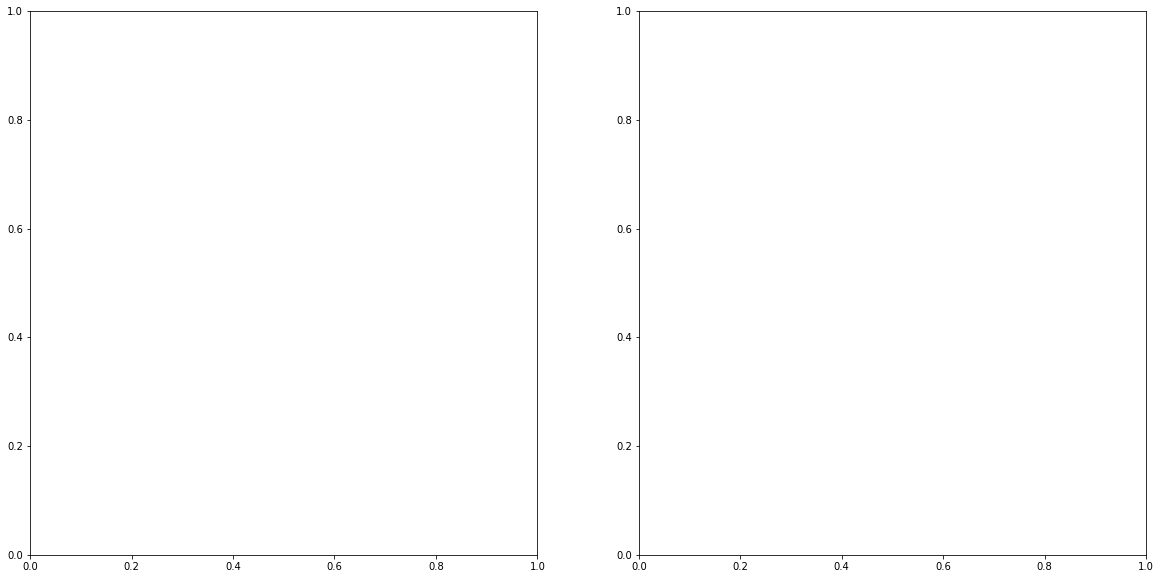

In [ ]:
def parse_args():
  parser = argparse.ArgumentParser('PaDim')
  parser.add_argument('--data_path', type=str, default='/content/drive/MyDrive/Padim/mvtec_anomaly_detection')
  parser.add_argument('--save_path', type=str,default='/content/drive/MyDrive/Padim/mvtec_anomaly_detection/mvtec_result')
  parser.add_argument('--arch', type=str, choices=['resnet18','wide_resnet50_2'], default='wide_resnet50_2')
  parser.add_argument('-f')
  return parser.parse_args()

model=''
def main():

  args= parse_args()
  global model
  # load model
  if args.arch =='resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 100

  elif args.arch =='wide_resnet50_2':
    model = Vit_modified('B_16_imagenet1k', pretrained=True)
    t_d = 1700
    d= 550
  model.to(device)
  model.eval()
  random.seed(1024)
  torch.manual_seed(1024)
  if use_cuda:
    torch.cuda.manual_seed_all(1024)
  idx = torch.tensor(sample(range(0,t_d),d))

  outputs=[]

  def hook(module, input, output):
    outputs.append(output)

  model.register_forward_hook(hook)
  model.register_forward_hook(hook)
  model.register_forward_hook(hook)


  os.makedirs(os.path.join(args.save_path, 'temp_%s' % args.arch), exist_ok=True)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  fig_img_rocauc= ax[0]
  fig_pixel_rocauc = ax[1]

  total_roc_auc= []
  total_pixel_roc_auc = []

  for class_name in CLASS_NAMES:
    train_dataset = MVTecDataset(args.data_path, class_name= class_name, is_train=True)
    train_dataloader= DataLoader(train_dataset,batch_size= 32, pin_memory=True)
    test_dataset = MVTecDataset(args.data_path, class_name= class_name, is_train=False)
    test_dataloader= DataLoader(test_dataset,batch_size= 32, pin_memory=True)

    train_outputs = OrderedDict([('layer1',[]),('layer2',[]),('layer3',[])])
    test_outputs = OrderedDict([('layer1',[]),('layer2',[]),('layer3',[])])

    # extract feature
    train_feature_filepath = os.path.join(args.save_path, 'temp_%s'% args.arch, 'train_%s.pkl'% class_name)
    if not os.path.exists(train_feature_filepath):
      for (x,_,_) in tqdm(train_dataloader,'| feature extraction| train | %s |' % class_name):
        #model prediction
        with torch.no_grad():
          _ = model(x.to(device))

        # get intermediate layer outputs
        for k, v in zip(train_outputs.keys(), outputs):
          train_outputs[k].append(v.cpu().detach())
        # initialize hook outputs
        outputs=[]

      for k,v in train_outputs.items():
        train_outputs[k] = torch.cat(v,0)


      # Embedding concat
      embedding_vectors = train_outputs['layer1']
      for layer_name in ['layer2','layer3']:
        embedding_vectors= embedding_concat(embedding_vectors, train_outputs[layer_name])

      # randomly select d dimension

      embedding_vectors = torch.index_select(embedding_vectors,1,idx)

      # calculate multivariate Gaussian distribution
      B, C, H, W = embedding_vectors.size()
      embedding_vectors = embedding_vectors.view(B, C, H * W)
      mean = torch.mean(embedding_vectors, dim=0).numpy()
      cov = torch.zeros(C,C,H*W).numpy()
      I = np.identity(C)
      for i in range(H*W):
        cov[:,:,i] = np.cov(embedding_vectors[:,:,i].numpy(),rowvar=False)+0.01 * I

      train_outputs = [mean,cov]
      with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs,f)
    else:
      print('load train set feature from: %s' % train_feature_filepath)
      with open(train_feature_filepath, 'rb') as f:
        train_outputs= pickle.load(f)
      
    gt_list = []
    gt_mask_list = []
    test_imgs = []

    for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
        test_imgs.extend(x.cpu().detach().numpy())
        gt_list.extend(y.cpu().detach().numpy())
        gt_mask_list.extend(mask.cpu().detach().numpy())
        # model prediction
        with torch.no_grad():
          _ = model(x.to(device))
        # get intermediate layer outputs
        for k, v in zip(test_outputs.keys(), outputs):
            #test_outputs[k].append(v[1].cpu().detach())
            test_outputs[k].append(v.cpu().detach())
         # initialize hook outputs
        outputs = []
    for k, v in test_outputs.items():
        test_outputs[k] = torch.cat(v, 0)
    # Embedding concat
    embedding_vectors = test_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

    # randomly select d dimension
    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
    # calculate distance matrix

    B,C,H,W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B,C,H*W).numpy()
    dist_list=[]
    print(np.linalg.det(train_outputs[1][:,:,0]))
    print(np.linalg.det(train_outputs[1][:,:,1]))
    for i in range(H*W):
      mean = train_outputs[0][:,i]
      dist = [distance.euclidean(sample[:,i],mean) for sample in embedding_vectors]
      dist_list.append(dist)

    dist_list = np.array(dist_list).transpose(1,0).reshape(B,H,W)

    #upsample
    dist_list = torch.tensor(dist_list)
    score_map = F.interpolate(dist_list.unsqueeze(1), size= x.size(2), mode='bilinear',
                                align_corners=False).squeeze().numpy()

    for i in range(score_map.shape[0]):
      score_map[i] = gaussian_filter(score_map[i], sigma=4)

    # Normalization

    max_score = score_map.max()
    min_score = score_map.min()
    scores = (score_map- min_score) / (max_score - min_score)

    # calculate image-level AUC score

    img_scores = scores.reshape(scores.shape[0],-1).max(axis=1)
    gt_list = np.asarray(gt_list)
    fpr, tpr, _ = roc_curve(gt_list, img_scores)
    img_roc_auc = roc_auc_score(gt_list, img_scores)
    total_roc_auc.append(img_roc_auc)
    print('image ROCAUC: %.3f' % (img_roc_auc))
    fig_img_rocauc.plot(fpr,tpr,label= '%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

    #get optimal threshold
    gt_mask = np.asarray(gt_mask_list)
    precision, recall, thresholds =precision_recall_curve(gt_mask.flatten(),scores.flatten())
    a = 2* precision * recall 
    b = precision + recall
    f1 = np.divide(a,b, out= np.zeros_like(a), where= b != 0)
    threshold = thresholds[np.argmax(f1)]

    # calculate per-pixel level ROCAUC
    fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
    per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
    total_pixel_roc_auc.append(per_pixel_rocauc)
    print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

    fig_pixel_rocauc.plot(fpr,tpr,label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
    save_dir = args.save_path + '/' + f'pictures_{args.arch}'
    os.makedirs(save_dir, exist_ok=True)
    plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, class_name)

  print('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
  fig_pixel_rocauc.legend(loc='lower right')

  fig.tight_layout()
  fig.savefig(os.path.join(args.save_path, 'roc_curve.png'), dpi=100)

def plot_fig(test_img,scores, gts, threshold, save_dir, class_name):
  num = len(scores)
  vmax = scores.max()*255.
  vmin = scores.min()*255.
  for i in range(num):
    img = test_img[i]
    img = denormalization(img)
    gt = gts[i].transpose(1,2,0).squeeze()
    heat_map = scores[i] * 255
    mask = scores[i]
    mask[mask > threshold] = 1
    mask[mask <= threshold] = 0
    kernel = morphology.disk(4)
    mask= morphology.opening(mask, kernel)
    mask *= 255
    vis_img = mark_boundaries(img, mask, color=(1,0,0), mode= 'thick')
    fig_img, ax_img = plt.subplots(1,5,figsize=(12,3))
    fig_img.subplots_adjust(right=0.9)
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    for ax_i in ax_img:
      ax_i.axes.xaxis.set_visible(False)
      ax_i.axes.yaxis.set_visible(False)
    ax_img[0].imshow(img)
    ax_img[0].title.set_text('Image')
    ax_img[1].imshow(gt, cmap='gray')
    ax_img[1].title.set_text('GroundTruth')
    ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
    ax_img[2].imshow(img,cmap='gray',interpolation='none')
    ax_img[2].title.set_text('Predicted heat map')
    ax_img[3].imshow(mask, cmap='gray')
    ax_img[3].title.set_text('Predicted mask')
    ax_img[4].imshow(vis_img)
    ax_img[4].title.set_text('Segmentation result')
    left=0.92
    bottom=0.15
    width = 0.015
    height = 1-2*bottom
    rect= [left, bottom, width, height]
    cbar_ax = fig_img.add_axes(rect)
    cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
    cb.ax.tick_params(labelsize=8)
    font={'family': 'serif','color': 'black','weight': 'normal','size': 8}
    cb.set_label('Anomaly Score', fontdict=font)

    fig_img.savefig(os.path.join(save_dir,class_name+ '_{}'.format(i)),dpi=100)
    plt.close()
    
def denormalization(x):
  mean= np.array([0.485,0.456,0.406])
  std= np.array([0.229,0.224,0.225])
  x= (((x.transpose(1,2,0)*std)+mean)*255.).astype(np.uint8)

  return x

def embedding_concat(x,y):
  B,C1,H1,W1 = x.size()
  _,C2,H2,W2 = y.size()
  s= int(H1/H2)
  x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
  x = x.view(B,C1, -1,H2,W2)
  z= torch.zeros(B, C1+C2,x.size(2),H2,W2)
  for i in range(x.size(2)):
    z[:,:,i,:,:]= torch.cat((x[:,:,i,:,:],y),1)
  z = z.view(B,-1,H2*W2)
  z = F.fold(z, kernel_size=s, output_size=(H1,W1),stride=s)

  return z

if __name__ == '__main__':
    main()
